# Document Classification Approach

**This code helps to build different classification model to classify documents to different classes. In this case into five different categories:** <br>
***TAX, AGGREMENTS, VALUATION, HUMAN RESOURCES, DEEDS***

### Importing the required libraries 

In [1]:
from subprocess import Popen, PIPE
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import io
from io import StringIO
import os
import glob
import docx
import comtypes.client
import sys
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

### Raw Data conversion and extraction
The raw data contains different file formats. Data needs to be extracted from them. Here doc files have been converted to PDF format first before extraction. I had issues while installing textract library which extracts test from the doc files directly, so I converted them to PDF and used pdfminer to extract texts.
Texts are extracted on folder basis because the extracted texts need to be labeled.

Another approach would be to convert the PDFs to HTML form and then extract the data from the tags. The PDFs when converted to HTML give the data inside tags, however when I converted them the data was all embedded in the <div> tags with no access to the unique heading tags or other data. So ended up extracting from PDFs.

### Code to convert all the doc files to PDF and store them in the same location

In [3]:
wdFormatPDF = 17 # selecting the PDF format 

filelocation = 'RawData/Taxes'

filelist=os.listdir(filelocation)
doccollection=[]
for files in filelist: #Traversing through all the files in the location to find the doc files
    files=os.path.join(filelocation,files)
    doccollection.append(files)
for x in doccollection:
    if x.endswith('.doc'):
        word = comtypes.client.CreateObject('Word.Application')
        doc = word.Documents.Open(os.path.abspath(x))
        doc.SaveAs(os.path.abspath(x+'.pdf'), FileFormat=wdFormatPDF)
        doc.Close()
        word.Quit()
        

### Function to extract the textual data from PDFs

In [2]:
import pandas as pd
def convert_pdf_to_txt(path):
    #alltexts = []
    filelist=os.listdir(path)
    documentcollection=[]
    for files in filelist:
        files=os.path.join(path,files)
        documentcollection.append(files)
    for ifiles in documentcollection:
        if ifiles.endswith('.pdf') or ifiles.endswith('.PDF'): #different extensions on the raw data
            with open(ifiles, 'rb') as fh:
                for page in PDFPage.get_pages(fh, 
                                              caching=True,
                                              check_extractable=True):
                    resource_manager = PDFResourceManager()
                    fake_file_handle = io.StringIO()
                    converter = TextConverter(resource_manager, fake_file_handle)
                    page_interpreter = PDFPageInterpreter(resource_manager, converter)
                    page_interpreter.process_page(page)
 
                    text = fake_file_handle.getvalue() # extraction of the text data
                    yield text
 
                    # closing open handles
                    converter.close()
                    fake_file_handle.close()
        
    #return alltexts

### Extraction of Taxes files and labelling

In [3]:
filepath='RawData/Taxes'
textcontents = convert_pdf_to_txt(filepath)
dftaxes = pd.DataFrame(textcontents, columns = ['Text_Data']) 
dftaxes['Category'] = 'Taxes' # Adding the taxes label

In [4]:
# Pre-processing the extracted textual data
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split())) # lower case conversion
dftaxes['Text_Data'] = dftaxes['Text_Data'].str.replace('[^\w\s]','') # getting rid of special characters
dftaxes['Text_Data'] = dftaxes['Text_Data'].str.replace('\d+', '') # removing numeric values from between the words
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: x.translate(string.digits)) # removing numerical numbers
stop = stopwords.words('english')
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #removing stop words
stemmer = WordNetLemmatizer()
dftaxes['Text_Data'] = [stemmer.lemmatize(word) for word in dftaxes['Text_Data']] #converting words to their dictionary form
dftaxes['Text_Data'] = dftaxes['Text_Data'].str.replace('shall', '')

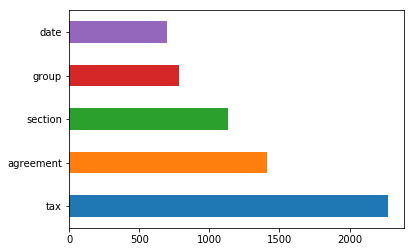

In [5]:
# Plotting 5 most occuring words in the 'Taxes' documents

taxfreq = pd.Series(' '.join(dftaxes['Text_Data']).split()).value_counts()[:5]
taxfreq.plot(kind='barh');
plt.show()

**Adding these top 5 words as an additional features to the dataframe which will be useful for classification algorithms**

In [6]:
dftaxes['Identifiers'] = 'tax,agreement,section,group,date'
dftaxes[:5]

,Text_Data,Category,Identifiers
0,tax indemnity agreement tax indemnity agreemen...,Taxes,"tax,agreement,section,group,date"
1,factor ii acquisition price series c share iss...,Taxes,"tax,agreement,section,group,date"
2,earnout dilution factor means respect earnout ...,Taxes,"tax,agreement,section,group,date"
3,turn appoint third appraiser determine fair v...,Taxes,"tax,agreement,section,group,date"
4,way diminution value notwithstanding anything ...,Taxes,"tax,agreement,section,group,date"


### Performing the same tasks on other category folders

In [7]:
filepath='RawData/Agreements'
agreementcontents = convert_pdf_to_txt(filepath)
dfagreement = pd.DataFrame(agreementcontents, columns = ['Text_Data']) 
dfagreement['Category'] = 'Agreement'

In [8]:
dfagreement['Text_Data'] = dfagreement['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfagreement['Text_Data'] = dfagreement['Text_Data'].str.replace('[^\w\s]','')
dfagreement['Text_Data'] = dfagreement['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfagreement['Text_Data'] = dfagreement['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
dfagreement['Text_Data'] = dfagreement['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stemmer = WordNetLemmatizer()
dfagreement['Text_Data'] = [stemmer.lemmatize(word) for word in dfagreement['Text_Data']]
dfagreement['Text_Data'] = dfagreement['Text_Data'].str.replace('shall', '')

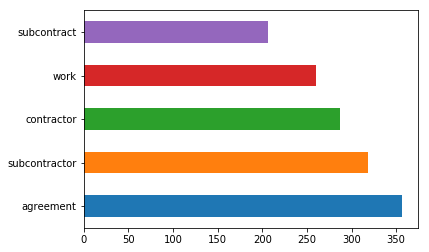

In [9]:
agfreq = pd.Series(' '.join(dfagreement['Text_Data']).split()).value_counts()[:5]
agfreq.plot(kind='barh');
plt.show()

In [10]:
dfagreement['Identifiers'] = 'agreement,subcontractor,contractor,work,subcontract'
dfagreement[:5]

,Text_Data,Category,Identifiers
0,agreement xxw amendment agreement among united...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
1,act september stat designated colorado river b...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
2,section party provides additional funding part...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
3,witness whereof parties hereto executed amendm...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
4,witness whereof parties hereto executed amendm...,Agreement,"agreement,subcontractor,contractor,work,subcon..."


In [11]:
filepath='RawData/Deeds'
deedscontents = convert_pdf_to_txt(filepath)
dfdeeds = pd.DataFrame(deedscontents, columns = ['Text_Data']) 
dfdeeds['Category'] = 'Deeds'

In [12]:
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].str.replace('[^\w\s]','')
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stemmer = WordNetLemmatizer()
dfdeeds['Text_Data'] = [stemmer.lemmatize(word) for word in dfdeeds['Text_Data']]
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].str.replace('shall', '')

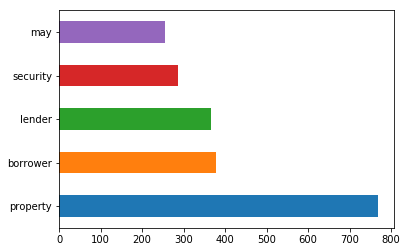

In [13]:
dfreq = pd.Series(' '.join(dfdeeds['Text_Data']).split()).value_counts()[:5]
dfreq.plot(kind='barh');
plt.show()

In [14]:
dfdeeds['Identifiers'] = 'property,borrower,lender,security,beneficiary'
dfdeeds[:5]

,Text_Data,Category,Identifiers
0,sample deed trust deed trust definitions words...,Deeds,"property,borrower,lender,security,beneficiary"
1,cid adjustable rate rider cid condominium ride...,Deeds,"property,borrower,lender,security,beneficiary"
2,q successor interest borrower means party take...,Deeds,"property,borrower,lender,security,beneficiary"
3,check drawn upon institution whose deposits in...,Deeds,"property,borrower,lender,security,beneficiary"
4,b leasehold payments ground rents property c p...,Deeds,"property,borrower,lender,security,beneficiary"


In [15]:
filepath='RawData/Valuations'
valuationcontents = convert_pdf_to_txt(filepath)
dfvaluation = pd.DataFrame(valuationcontents, columns = ['Text_Data']) 
dfvaluation['Category'] = 'Valuations'

In [16]:
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].str.replace('[^\w\s]','')
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
stemmer = WordNetLemmatizer()
dfvaluation['Text_Data'] = [stemmer.lemmatize(word) for word in dfvaluation['Text_Data']]
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

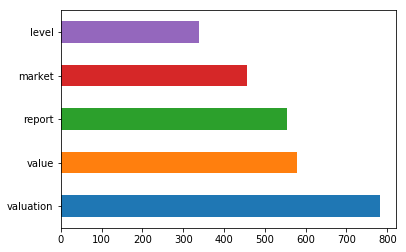

In [17]:
valfreq = pd.Series(' '.join(dfvaluation['Text_Data']).split()).value_counts()[:5]
valfreq.plot(kind='barh');
plt.show()

In [18]:
dfvaluation['Identifiers'] = 'valuation,value,report,market,level'
dfvaluation[:5]

,Text_Data,Category,Identifiers
0,valuation reportbusiness valuation trends stra...,Valuations,"valuation,value,report,market,level"
1,valuation report spring technical topicsthe im...,Valuations,"valuation,value,report,market,level"
2,spring valuation reportlitigation update dlom ...,Valuations,"valuation,value,report,market,level"
3,publication distributed understanding author p...,Valuations,"valuation,value,report,market,level"
4,november actuarialvaluationreportguaranteededu...,Valuations,"valuation,value,report,market,level"


In [19]:
filepath='RawData/Human Resources'
hrcontents = convert_pdf_to_txt(filepath)
dfhr = pd.DataFrame(hrcontents, columns = ['Text_Data']) 
dfhr['Category'] = 'Human Resources'

In [20]:
dfhr['Text_Data'] = dfhr['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfhr['Text_Data'] = dfhr['Text_Data'].str.replace('[^\w\s]','')
dfhr['Text_Data'] = dfhr['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfhr['Text_Data'] = dfhr['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
dfhr['Text_Data'] = dfhr['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stemmer = WordNetLemmatizer()
dfhr['Text_Data'] = [stemmer.lemmatize(word) for word in dfhr['Text_Data']]
dfhr['Text_Data'] = dfhr['Text_Data'].str.replace('may', '')

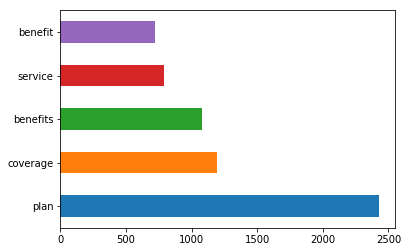

In [21]:
hrfreq = pd.Series(' '.join(dfhr['Text_Data']).split()).value_counts()[:5]
hrfreq.plot(kind='barh');
plt.show()

In [22]:
dfhr['Identifiers'] = 'plan,coverage,benefits,service,level'
dfhr[:5]

,Text_Data,Category,Identifiers
0,volunteer coordinators job description general...,Human Resources,"plan,coverage,benefits,service,level"
1,cid participate volunteer evaluations assigned...,Human Resources,"plan,coverage,benefits,service,level"
2,hiring company name texas ballet theater hirin...,Human Resources,"plan,coverage,benefits,service,level"
3,oversee community enrichment citydance outreac...,Human Resources,"plan,coverage,benefits,service,level"
4,dynamic energetic creative socially adept demo...,Human Resources,"plan,coverage,benefits,service,level"


### Merging all the data with the labels for further processing

In [23]:
frames = [dftaxes, dfagreement, dfdeeds, dfvaluation, dfhr]
finalframe = pd.concat(frames,sort=False)
finalframe = finalframe[['Identifiers','Text_Data','Category']]
finalframe = finalframe.reset_index(drop=True)
finalframe[:5]

,Identifiers,Text_Data,Category
0,"tax,agreement,section,group,date",tax indemnity agreement tax indemnity agreemen...,Taxes
1,"tax,agreement,section,group,date",factor ii acquisition price series c share iss...,Taxes
2,"tax,agreement,section,group,date",earnout dilution factor means respect earnout ...,Taxes
3,"tax,agreement,section,group,date",turn appoint third appraiser determine fair v...,Taxes
4,"tax,agreement,section,group,date",way diminution value notwithstanding anything ...,Taxes


## Analysis of the extracted data
The extracted data has to analyzed for anamolies and other insights which can be used to process them further

### Counting the data points of each category

We can see that we have a lot of data for human resources and very less for agreements category. This suggests that the data is imbalanced and needs data augmentation. Under sampling was not an option because of the already small dataset which leads to less performance of the model overall. So over sampling is one of the options that needs to be taken into consideration.

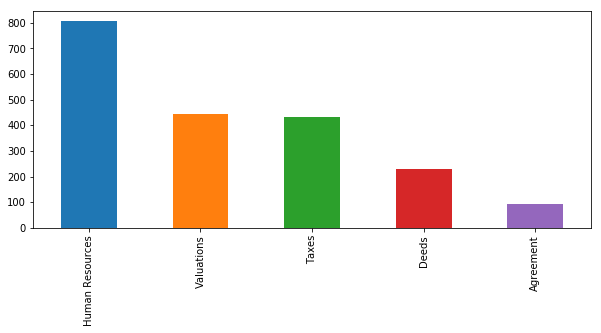

In [24]:
import matplotlib.pyplot as plt
my_tags = ['Agreements','Deeds','Taxes','Human Resources','Valuations']
plt.figure(figsize=(10,4))
finalframe.Category.value_counts().plot(kind='bar');
plt.show()

### Building different models for classification of the documents

Training data after using TF-IDF. Term Frequency - Inverse document frequency takes care of the assigning vectors to the word based on the frequency of them occuring in each document. 

In [25]:
# Converting the text data into vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import LabelEncoder
# Generating 1000 features for the input for the model
tfidfconverter = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english')) 
X = pd.DataFrame(tfidfconverter.fit_transform(finalframe['Text_Data']).toarray())
print(X[:5])
#X.columns = range(X.shape[1])
labelencoder = LabelEncoder() #Converting the labels to numeric labels
y = labelencoder.fit_transform(finalframe['Category'])

   0         1    2    3    4         5         6    7         8    9   ...   \
0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0 ...    
1  0.0  0.000000  0.0  0.0  0.0  0.000000  0.075627  0.0  0.000000  0.0 ...    
2  0.0  0.077873  0.0  0.0  0.0  0.057588  0.000000  0.0  0.000000  0.0 ...    
3  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0 ...    
4  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.061452  0.0 ...    

   990  991       992       993  994  995  996  997  998  999  
0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.000000  0.062047  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.000000  0.059795  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.042755  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1000 columns]


In [26]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  

### Oversampling the data to get well balanced classes for model building

In [27]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [29]:
import numpy as np
unique, counts = np.unique(y_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 807]
 [  1 807]
 [  2 807]
 [  3 807]
 [  4 807]]


### Oversampling has made all the classes equally balanced with 807 data points each

In [30]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)  

## Building different models and comparing their performances

## Random Forest Classifier

Random Forest is an ensemble model of decision trees. Here it is used to classify the features into different categories. The reason I decided to go with RFC is beacuse of it's robustness on small datasets. 

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
classifier = RandomForestClassifier(n_estimators=1200, random_state=1)  #defining 1000 nodes 
rf = classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test) 

Accuracy: 0.9405204460966543
                 precision    recall  f1-score   support

     Agreements       0.79      1.00      0.88       163
          Deeds       0.99      0.99      0.99       166
          Taxes       1.00      0.79      0.88       151
Human Resources       0.98      0.97      0.98       151
     Valuations       1.00      0.94      0.97       176

      micro avg       0.94      0.94      0.94       807
      macro avg       0.95      0.94      0.94       807
   weighted avg       0.95      0.94      0.94       807

Confusion matrix:
 [[163   0   0   0   0]
 [  2 164   0   0   0]
 [ 29   0 119   3   0]
 [  4   0   0 147   0]
 [  8   2   0   0 166]]


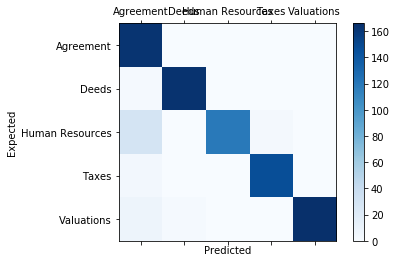

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred,target_names=my_tags))  
#print(confusion_matrix(y_test,y_pred)) 

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [53]:
# Saving model to disk
import pickle
import requests
import json
pickle.dump(rf, open('rfmodel.pkl','wb'))

**It can be seen that the random forest classifier gives an accuracy of around 94% and performs well for classification with good F1 scores. It is predicting almost the right classes for the test data with few false positives and negatives**

## Naive Bayes Classifier

NBC is based on describing counts among number of categories so it is used in text classification where the features are related to word counts or frequencies within the document to be classified.

Accuracy: 0.9231722428748451
                 precision    recall  f1-score   support

     Agreements       0.96      0.83      0.89       163
          Deeds       0.96      0.95      0.95       166
          Taxes       0.80      0.98      0.88       151
Human Resources       0.96      0.94      0.95       151
     Valuations       0.96      0.92      0.94       176

      micro avg       0.92      0.92      0.92       807
      macro avg       0.93      0.92      0.92       807
   weighted avg       0.93      0.92      0.92       807

Confusion matrix:
 [[136   2  23   0   2]
 [  2 157   2   2   3]
 [  1   0 148   2   0]
 [  2   1   5 142   1]
 [  1   3   8   2 162]]


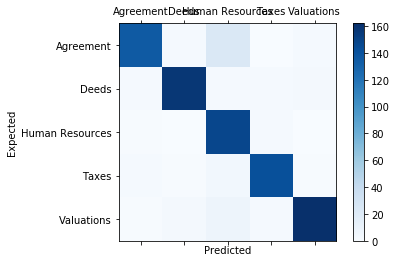

In [40]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [54]:
pickle.dump(clf, open('nbmodel.pkl','wb'))

**Naive Bayes classifier gives an accuracy of around 92% and performs well for classification with good F1 scores. It is predicting almost the right classes for the test data with few false positives and negatives**

## XGBoost Classifier

Extreme Gradiant Boosting algorithm is an tree ensemble model which is optimized to predict quicker by utilizing available resources and takes care of over fitting. 

Accuracy: 0.9417596034696406
                 precision    recall  f1-score   support

     Agreements       1.00      0.86      0.92       163
          Deeds       0.98      0.97      0.97       166
          Taxes       0.79      0.99      0.88       151
Human Resources       0.98      0.97      0.98       151
     Valuations       0.99      0.93      0.96       176

      micro avg       0.94      0.94      0.94       807
      macro avg       0.95      0.94      0.94       807
   weighted avg       0.95      0.94      0.94       807

Confusion matrix:
 [[140   0  23   0   0]
 [  0 161   3   2   0]
 [  0   0 149   1   1]
 [  0   0   4 147   0]
 [  0   4   9   0 163]]


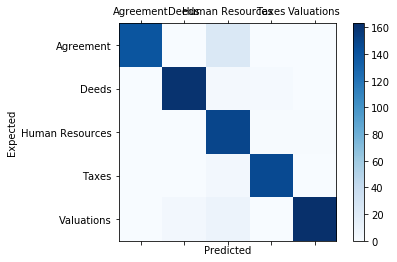

In [41]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %s" % (accuracy))
print(classification_report(y_test, y_pred,target_names=my_tags))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [55]:
pickle.dump(xgb, open('xgbmodel.pkl','wb'))

**XGBoost classifier gives an accuracy of around 94% and performs well for classification with good F1 scores. It is predicting almost the right classes for the test data with few false positives and negatives**

## Word2Vec model

Word2vec is a neural network based model which generates vectors for words based on their frequent co-occurances with each other. It is more useful for finding contents and its sub-contents wherever necessary and works great when dealing with large datasets.

### Here I am using a 300 dimension negative google news pre-trained word vectors for vectorization of words in the document

In [42]:
import gensim
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True) # Pre-trained word vectors
wv.init_sims(replace=True)

In [45]:
finalframe['Text_Data'].apply(lambda x: len(x.split(' '))).sum()
finalframe['Identifiers'].apply(lambda x: len(x.split(' '))).sum()

2005

In [46]:
# Defining function to assign vectors from pre-trained model
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [47]:
#function to split indiviual words from the sentences
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2 and len(word) > 12:
                continue
            tokens.append(word)
    return tokens

### Preparing the training and testing dataset

In [48]:
import nltk
train, test = train_test_split(finalframe, test_size=0.3, random_state = 42)
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Text_Data']), axis=1).values
label_test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Category']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Text_Data']), axis=1).values

In [49]:
import numpy as np
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)
y_test_word_average = word_averaging_list(wv,label_test_tokenized)

### Building Logistic regression model for classification

In [50]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['Category'])
y_pred = logreg.predict(X_test_word_average)

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, test.Category))
print(classification_report(test.Category, y_pred,target_names=my_tags))

accuracy 0.9385382059800664
                 precision    recall  f1-score   support

     Agreements       0.84      0.81      0.82        26
          Deeds       0.91      0.94      0.92        71
          Taxes       0.92      0.98      0.95       244
Human Resources       0.98      0.88      0.92       136
     Valuations       0.98      0.94      0.96       125

      micro avg       0.94      0.94      0.94       602
      macro avg       0.92      0.91      0.92       602
   weighted avg       0.94      0.94      0.94       602



In [52]:
pickle.dump(logreg, open('w2vmodel.pkl','wb'))

**Word2Vec classifier model gives an accuracy of around 94% and performs well for classification with good F1 scores. It is predicting almost the right classes for the test data with few false positives and negatives**

## Doc2Vec Model

Doc2Vec is similar to Word2Vec but instead of learning feature representations for each word, it learns for each document. In this case it provides a unique tag name for words of every page in the document. 

In [56]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import doc2vec
from sklearn import utils
import gensim
import re
from gensim.models.doc2vec import LabeledSentence

In [57]:
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [58]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence
X_train, X_test, y_train, y_test = train_test_split(finalframe.Text_Data, finalframe.Category, random_state=2, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [59]:
X_train[2:4]

[TaggedDocument(words=['page', 'step', 'design', 'implement', 'career', 'development', 'strategies', 'strategic', 'leadership', 'team', 'evaluated', 'bench', 'strength', 'prioritized', 'key', 'leadership', 'positions', 'attention', 'shifts', 'continued', 'career', 'development', 'employees', 'determined', 'eligible', 'potentially', 'eligible', 'positions', 'step', 'succession', 'planning', 'process', 'focused', 'helping', 'employees', 'managers', 'discuss', 'career', 'development', 'plans', 'discussing', 'encouraging', 'career', 'development', 'employees', 'important', 'part', 'management', 'however', 'purpose', 'succession', 'planning', 'increasing', 'bench', 'strength', 'specified', 'areas', 'selection', 'subset', 'employees', 'upon', 'focus', 'career', 'development', 'efforts', 'necessary', 'annual', 'performance', 'review', 'session', 'provides', 'excellent', 'opportunity', 'begin', 'discussions', 'career', 'development', 'goal', 'opportunities', 'however', 'managers', 'need', 'kee

In [60]:
model_dbow = Doc2Vec()
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|█████████████████████████████████████████████████████████████████████████| 2005/2005 [00:00<00:00, 2011861.13it/s]


### Training manually to get the word vectors rather than relying on pre-trained vectors

In [61]:
for epoch in range(45):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 2005/2005 [00:00<00:00, 2096106.56it/s]


In [62]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [63]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 100, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 100, 'Test')

### Building a logistic regression model for classification using Doc2Vec

In [64]:
logreg = LogisticRegression()
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [65]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [66]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.840531561461794
                 precision    recall  f1-score   support

     Agreements       1.00      0.65      0.79        34
          Deeds       0.85      0.56      0.67        63
          Taxes       0.78      0.98      0.87       258
Human Resources       0.95      0.85      0.90       126
     Valuations       0.88      0.73      0.80       121

      micro avg       0.84      0.84      0.84       602
      macro avg       0.89      0.75      0.80       602
   weighted avg       0.85      0.84      0.84       602



**Doc2Vec doesn't perform well when dealing with less textual data but it can perform well on huge data sets, like in enterprises**

## Demo of the trained model in action
As the different models have been trained we have to test it out on a random document to see how the model classifies. The document should not belong in the dataset used to train or test.

In [79]:
#Loading the saved model and a random PDF file to test classification
savedmodel = pickle.load(open('nbmodel.pkl','rb'))
demofile = '2kvIrB7fXK3MSY6fIorOhe.pdf'

In [80]:
# Parsing through the sample document and extracting the textual data
def convert2txt():
    alltexts = []
    with open(demofile, 'rb') as fh:
        rsrcmgr = PDFResourceManager()
        retstr = StringIO()
        codec = 'utf-8'
        laparams = LAParams()
        device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        fp = open(demofile, 'rb')
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        password = ""
        maxpages = 0
        caching = True
        pagenos=set()

        for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
            interpreter.process_page(page)

        text = retstr.getvalue()
        alltexts.append(text)
        fp.close()
        device.close()
        retstr.close()
        
    return alltexts 

In [81]:
textdata = convert2txt()

In [82]:
# Feature engineering to get the data in right format
dfdemo = pd.DataFrame(textdata, columns = ['Data'])
dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(x.lower() for x in x.split())) # lower case conversion
dfdemo['Data'] = dfdemo['Data'].str.replace('[^\w\s]','') # getting rid of special characters
dfdemo['Data'] = dfdemo['Data'].str.replace('\d+', '') # removing numeric values from between the words
dfdemo['Data'] = dfdemo['Data'].apply(lambda x: x.translate(string.digits)) # removing numerical numbers
stop = stopwords.words('english')
dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #removing stop words
stemmer = WordNetLemmatizer()
dfdemo['Data'] = [stemmer.lemmatize(word) for word in dfdemo['Data']]

In [83]:
# Assigning vectors to the input data
tfidfconverter = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english'))
inputs = pd.DataFrame(tfidfconverter.fit_transform(dfdemo['Data']).toarray())
inputs

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.00286,0.00286,0.00286,0.00286,0.00286,0.00858,0.00572,0.00286,0.01144,0.01716,...,0.051481,0.048621,0.00286,0.00858,0.00286,0.01144,0.01144,0.034321,0.00286,0.031461


### Prediction on the sample file

In [84]:
# Predicting the category of the input file with the help of trained model

output_category = savedmodel.predict(inputs)
#Comment the next line if you are testing word2vec model as it doesn't require transformation
output_category = (labelencoder.inverse_transform((output_category)))
output_category

array(['Human Resources'], dtype=object)

## Conclusion

The saved model has correctly predicted the class of the input file. The saved model was Naive Bayes Classifier which had predicting accuracy of around 93% with a good precision for all classes above 90%. 
Different classification models can be trained for this task and comapred for their perfomances. 